# Artificial networks

In [14]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import ConnectionPatch
from matplotlib import animation
import ipywidgets as widgets
from scipy import optimize as opt
from urllib.request import urlopen
from PIL import Image
from io import BytesIO

%matplotlib inline

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

# from pylab import *
from sklearn.datasets import fetch_openml

# Perceptron

<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_9/static/perceptron.png" width="400"/>
</div>

The perceptron is known as the first artificial neuron. It calculates its output with the following equation

\begin{equation*}
y=\begin{cases}
    1,  & \text{if } \mathbf{w}\cdot\mathbf{x} \geq 0 \\
    0,  & \text{otherwise}
\end{cases}
\end{equation*}

where $x_0$ is always 1 and therefore $w_0$ can be interpreted as the threshold $\theta$. Below is the very simple code for the perceptron

In [3]:
def perceptron(x, w):  
    return np.dot(w, x) >= 0

With linearly seperable data points, the perceptron can learn the synaptic weights to classify the data. We want to look at the algorithm

### Task 1

Can you implement the perceptron algorithm ?


<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_9/static/learning_algorithm_perceptron.png" width="400"/>
</div>

Try to implement the algorithm in the code below at the indicated position

In [52]:
starting_weights_seed = 18
np.random.seed(0) 

n_samples = 40 # number of samples

X = np.random.rand(2,n_samples)*1.1 # create random samples X
labels = X[0,:] + X[1,:]  >=1 # create the corresponding labels


X = np.vstack((np.ones(n_samples), X)) # include x_0 that is always 1 - the bias


np.random.seed(starting_weights_seed)
w = np.random.rand(3) # initialize a random connectivity matrix to start with (includes w_0)
np.random.seed(10)


all_w = w[None,:] # this is an array 
selected_points = [None] # this is a list

''' put the algorithm here '''
# be sure to include the following two lines after every step
# otherwise the viusalization in the end does not work
            



def scroll_through_weights(nn):


    fig,ax = plt.subplots(figsize = (8,8))
    
    w = all_w[nn,:]
    labels = perceptron(X, w) # get the classification results from the perceptron

    data_true = ax.scatter(*X[1:,labels], color = 'b', label = 'classified as True', s=90)
    data_false = ax.scatter(*X[1:,labels == False], color = 'r', label = 'classified as False', s=90)
    if len (selected_points) > nn+1:
        ax.scatter(*selected_points[nn+1][1:], color = (0,0,0,0), edgecolor='k', linewidth=2, s=90 )
    
    m = - w[1]/w[2]
    b = - w[0]/w[2]  
    xx = np.linspace(-0.1,1.1,2)
    ax.plot(xx, xx*m + b, color='k', linestyle = '--', label = 'decision boundary')
    
    
    
    ax.set(
        xlabel = r'$x_1$',
        ylabel = r'$x_2$')

    x_ticks = [0,0.5,1]
    y_ticks = [0,0.5,1]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks,fontsize=20)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks,fontsize=20)
    ax.set_xlabel('$x_1$', fontsize=32, fontweight='bold')
    ax.set_ylabel('$x_2$', fontsize=32, fontweight='bold')
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.legend()

    
widgets.interactive(scroll_through_weights, nn = (0,all_w.shape[0]-1,1))




interactive(children=(IntSlider(value=0, description='nn', max=0), Output()), _dom_classes=('widget-interact',…

### [Solution 1](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_9/solutions/78a5a35c0791e03abff0b965447c82b9.txt)


### Task 2

In the example above, the data was linearly seperable. What happens if its not?

## Hopfield network

In contrast to the perceptron and the deep learning algorithms that were developed afterwards, the hopfield network takes a different approach and uses the interaction of single units to create an emergent property, the concept of a memory. 

<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_9/static/hopfield.png" width="600"/>
</div>

Below you find the class of a Hopfield network. Go through the code and compare it with the lecture. 

In [36]:
class HopfieldNetwork(object):
    """docstring for HopfieldNetwork

    patterns: np.array with shape (n_of_patterns, dim_of_patterns)
    """

    def __init__(self, 
        training_patterns,
        training_labels,
        store_overlap_with_training_data=False):
        super(HopfieldNetwork, self).__init__()

        self.training_patterns = training_patterns
        self.training_labels = training_labels

        self.n_training_patterns = self.training_patterns.shape[0]
        self.dim_patterns = self.training_patterns.shape[1]
        self.init_network()

        self.current_target_pattern = self.training_patterns[0]
        self.current_target_label = self.training_labels[0]

        self.store_overlap_with_training_data = store_overlap_with_training_data

    def init_network(self):
        # Initialize weights to zero values
        self.W = np.zeros([self.dim_patterns, self.dim_patterns])

    def train(self):
        # Accumulate outer products
        for pattern in self.training_patterns:
            self.W += np.outer(pattern, pattern)

        # Divide times the number of patterns
        self.W /= float(self.n_training_patterns)

        # Exclude the autoconnections
        self.W *= 1.0 - np.eye(self.dim_patterns)

    def run_simuation(
        self,
        noise=0.2,  # 0 = no noise, 1 = only noise
        sim_time=5500,  # timesteps
        frames_to_save=100,
        target_pattern = np.array([]),
        target_label = None,
        save_simulation = True,
        synchrounous_update = False,
        start_inverse = False,
    ):
        if target_pattern.size != 0:
            self.current_target_pattern = target_pattern
            self.current_target_label = target_label



        sample_interval = sim_time // frames_to_save

        self.store_images = np.zeros([self.dim_patterns, frames_to_save])
        
        x = self.current_target_pattern.copy()
        
        if start_inverse == True:
            x[:] *= -1

        # We randomly perturb the initial image by swapping the values
        mask = np.sign(np.random.random(self.dim_patterns) - noise)
        random_array = np.sign(np.random.random(self.dim_patterns)-0.5)
        x[mask == -1] = random_array[mask == -1]
        
        

        # During the iterations we ranomly select a unit to update
        x_indices = np.arange(self.dim_patterns)
        np.random.shuffle(x_indices)


        # the iterations
        for tt in range(sim_time):
            
            # Store current activations
            if tt % sample_interval == 0:
                # array containing frames_to_save of network activation
                self.store_images[:, tt // sample_interval] = x
                    

            if synchrounous_update:
                x = np.sign(np.dot(self.W,x))
            else:
                # get a random index 
                current_x = x_indices[tt % self.dim_patterns]
                # Activation of a unit
                x[current_x] = np.sign(np.dot(self.W[current_x, :], x))


            


        print ('simulation finished')

        if save_simulation:
            self.save_simulation()

    def init_figure(self):

        fig, ax = plt.subplots(1,3, figsize=(15,5))

        # Plot 1 - showing the target digit
        # Create subplot
        ax1 = ax[0]
        ax1.set_title("Start")
        # Create the imshow and save the handler
        self.display_image(ax1, self.store_images[:,0]) 
        
        
        # Plot 2 - plot the state of the network

        # Create subplot
        ax2 = ax[1]
        ax2.set_title("Recalling")

        # Create the imshow and save the handler
        im_activation = self.display_image(ax2, self.store_images[:,0]) 
        
        ax6 = ax[2]
        ax6.set_title("Target")
        # Create the imshow and save the handler
        im_target = self.display_image(ax6, self.current_target_pattern) 


       
        # return plot handlers
        return fig, im_target, im_activation

        
    def to_mat(self, pattern):
        img_dim = int(np.sqrt(self.dim_patterns))
        return pattern.reshape(img_dim,img_dim)
    
    def display_image(self, ax, img_array,cmap='binary'):
        im = ax.imshow(self.to_mat(img_array), 
                    interpolation = 'none', 
                    aspect = 'auto',
                    cmap = cmap) 
        ax.axis('off')
        return im
    
    
    def save_simulation(self):
        fig, im_target, im_activation = self.init_figure()
        
        frames = [t for t in range(self.store_images.shape[1])]

        def update(t,
            im_activation=im_activation, 
            im_energy=im_energy,
            im_errors=im_errors,) :
            
            
            A = np.squeeze(self.store_images[:,t])
            im_activation.set_array(self.to_mat(A))

        # Create and render the animation
        anim = animation.FuncAnimation(fig, func = update,  frames = frames )
        # save it to file
        anim.save(f"hopfield_{self.current_target_label}.gif",
                  fps = 10, writer='imagemagick',dpi=50)
        
    def visualize_results(self, t = 99):
        
        fig, im_target, im_activation = self.init_figure()
        A = np.squeeze(self.store_images[:,t])
        im_activation.set_array(self.to_mat(A))
       

Here we load 10 different pixelated images, that we can try to store in the Hopfield network

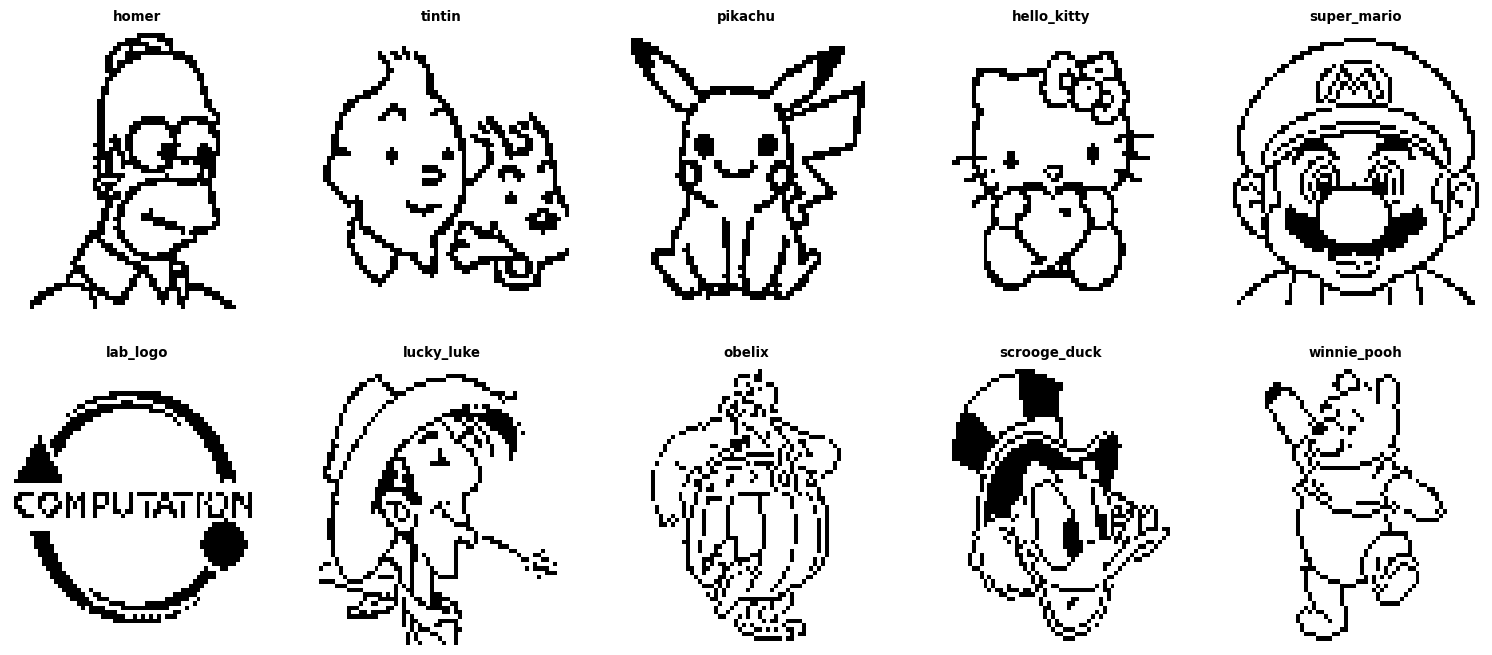

In [15]:
def load_binary_images_and_labels(
    labels = ['homer', 'tintin', 'pikachu', 'hello_kitty','super_mario', 'lab_logo',
              'lucky_luke','obelix','scrooge_duck','winnie_pooh'],
    show_images = False):
    
    images = np.array([])
    
    
    
    for name in labels:
    
        url = f'https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_9/static/pixel_images_{name}.png'
        response = requests.get(url)
        img = np.array(Image.open(BytesIO(response.content)))[:,:,0] # just use one channel

        binary_image = -1 * np.ones_like(img)
        binary_image[img < 100] = 1
   
        if images.size == 0:
            images = binary_image.flatten()[None,:]
        else:
            images = np.vstack((images, binary_image.flatten()[None,:]))

            
            
    if show_images:
        
        fig, axes = plt.subplots(2,5, figsize = (19,8))
        
        for img, ll, ax in zip(images, labels, axes.flatten()):
            ax.imshow(img.reshape(64,64),cmap='binary',interpolation = 'none', 
                    aspect = 'auto')
            ax.set_title(ll)
            ax.axis('off')

    return images, labels


load_binary_images_and_labels(show_images=True);

### Task 3 - investigate the network

Below you can play around with the network, take different images to train the network and see how the network retrieves them.
You can see all the available images in the list "labels" of the function _load_binary_images_and_labels_ above.

Try and recreate the sucess but also the problems from Hopfield networks discussed in the lecture.

In addition, if a memory is imprinted into the network, the inverse is always imprinted as well. You can test it by setting the changing the starting condition "start_inverse=False" 

In [40]:
images, labels = load_binary_images_and_labels(['pikachu', 'hello_kitty', 'scrooge_duck'])

test_network = HopfieldNetwork(
    training_patterns = images,
    training_labels = labels)
test_network.train()

In [47]:
frames = 100

test_network.run_simuation(
    noise=.5,
    target_pattern= images[2],
    target_label=labels[2],
    synchrounous_update = False,
    sim_time=5500,
    frames_to_save = frames,    
    save_simulation = False,
    start_inverse = False)


widgets.interactive(test_network.visualize_results, t=(0,frames-1, 1))

simulation finished


interactive(children=(IntSlider(value=99, description='t', max=99), Output()), _dom_classes=('widget-interact'…

### Task 4

Can you store and recall all 10 patterns in the network?
Take some time to think about the task and actually try something out before you check the solution.
If it does not work on the first try, try something else, get creative.

Also, if you think your solution should solve the problem but it does not, make sure to save your approach.

In [23]:
images_many, labels_many = load_binary_images_and_labels(
                ['homer', 'tintin', 'pikachu', 'hello_kitty','super_mario', 'lab_logo',
              'lucky_luke','obelix','scrooge_duck','winnie_pooh']
                )

''' put your code here '''

test_network = HopfieldNetwork(
    training_patterns = images_many,
    training_labels = labels_many)
test_network.train()

### [Possible Solution 4](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_9/solutions/07e5a35c07ab403abff0b965447c82c4.txt)



You can then test whether your solution works by executing the cell below 

In [24]:
frames = 100
target_index = 9

test_network.run_simuation(
    noise=0.4,
    target_pattern= images_many[target_index],
    target_label=labels_many[target_index],
    synchrounous_update = False,
    sim_time=5500,
    frames_to_save = frames,    
    save_simulation = False)

print (f'we search for: {labels_many[target_index]}')
final_network = test_network.store_images[:,-1].astype(int)
for label in labels_many:
    
    possible_target = map_target_name_to_pattern(label, N=len(labels_many)).astype(int)
    if np.all(final_network == possible_target):
        print ('we find: ', label)
    

widgets.interactive(test_network.visualize_results, t=(0,frames-1, 1))

simulation finished
we search for: winnie_pooh


interactive(children=(IntSlider(value=99, description='t', max=99), Output()), _dom_classes=('widget-interact'…